In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import awswrangler

In [2]:
session = awswrangler.Session()
df = session.pandas.read_sql_athena(
    sql="select * from resellers_sample",
    database="implementationdb"
)

In [4]:
df_r = session.pandas.read_sql_athena(
    sql="select * from reseller",
    database="implementationdb"
)

In [5]:
df.head()

,id_reseller,date,bill
0,499926634,2019-01-02,38504.944
1,499926634,2019-01-04,28435.291
2,499926634,2019-01-08,60980.544
3,499926634,2019-01-11,53897.648
4,499926634,2019-01-15,2280.933


In [6]:
df_r.head()

,id_reseller,zone,cluster
0,499929090,1019,A
1,499929094,1019,A
2,499929097,1019,A
3,499929098,1019,A
4,499929163,1014,A


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47407 entries, 0 to 47406
Data columns (total 3 columns):
id_reseller    47407 non-null Int64
date           47407 non-null object
bill           47407 non-null float64
dtypes: Int64(1), float64(1), object(1)
memory usage: 1.1+ MB


In [8]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12358 entries, 0 to 12357
Data columns (total 3 columns):
id_reseller    12358 non-null Int64
zone           12358 non-null Int64
cluster        12358 non-null object
dtypes: Int64(2), object(1)
memory usage: 313.9+ KB


In [9]:
df['date'] = pd.to_datetime(df['date'])

### Filter Last 4 Months

In [10]:
max_date = df['date'].max()
min_date = max_date - pd.to_timedelta(120, unit='d')
df = df[df['date'] > min_date]

## Exploratory Data Analysis

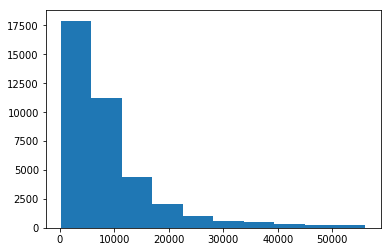

In [11]:
plt.hist(df[df["bill"] < df["bill"].quantile(0.95)]['bill']);

### Mean by day

Let's also analyse the mean by day to see if there's a trend or pattern in time

In [12]:
df_mean_by_day = df.groupby('date')['bill'].mean()

In [13]:
r = pd.date_range(start=min_date, end=max_date)
df_mean_by_day = df_mean_by_day.reindex(r).rename_axis('date').reset_index().fillna(0)

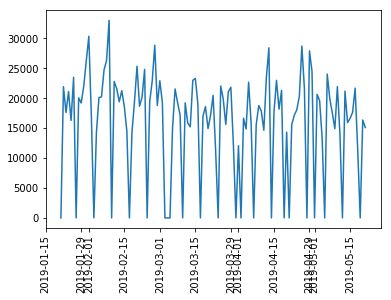

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.plot(df_mean_by_day['date'], df_mean_by_day['bill'])
plt.xticks(rotation='vertical');

In [15]:
def completeItem(dfItem):
    min_date = dfItem['date'].min()
    max_date = dfItem['date'].max()
    if min_date == max_date:
        #only one data point
        return
    r = pd.date_range(start=min_date, end=max_date)
    dfItemNew = dfItem.set_index('date').reindex(r).rename_axis('date').reset_index()
    
    dfItemNew['mean-last-30'] = dfItemNew['bill'].rolling(30,min_periods=1).mean().reset_index()['bill']
    dfItemNew['mean-last-7'] = dfItemNew['bill'].rolling(7,min_periods=1).mean().reset_index()['bill']
    dfItemNew['std-last-30'] = dfItemNew['bill'].rolling(30,min_periods=1).std().reset_index()['bill']
    dfItemNew['bill'] = dfItemNew['bill'].fillna(0)
    dfItemNew['id_reseller'] = dfItem['id_reseller'].max()
    dfItemNew['std-last-30'].fillna(method='ffill',inplace=True)
    dfItemNew['mean-last-7'].fillna(method='ffill',inplace=True)
    dfItemNew['std-last-30'].fillna(method='ffill',inplace=True)
    resp = []
    counter = 0
    for index,row in dfItemNew.iterrows(): 
        resp.append(counter)
        if row['bill'] == 0: 
            counter += 1 
        else:
            counter = 0
    dfItemNew['days_without_purchase'] = pd.Series(resp)
    return dfItemNew

In [16]:
i = 0
dfCompletedList = []
for nid,item in df.groupby('id_reseller'):
    i = i+1
    if i%200 == 0:
        print ('processed {} resellers'.format(str(i)))
    dfCompletedList.append(completeItem(item))

processed 200 resellers
processed 400 resellers
processed 600 resellers
processed 800 resellers
processed 1000 resellers
processed 1200 resellers


In [17]:
df = pd.concat(dfCompletedList).copy()
del dfCompletedList
df['weekday']  = df['date'].dt.weekday_name


In [18]:
df['next_bill'] = df.replace(0,np.nan).groupby('id_reseller')['bill'].fillna(method='bfill')

In [19]:
df['last_bill'] = df.replace(0,np.nan).groupby('id_reseller')['bill'].fillna(method='ffill').copy()
different_zero = df['last_bill'].shift(1)
df.loc[df['bill'] != 0,'last_bill'] = np.nan
df['last_bill'] = df['last_bill'].fillna(different_zero)

In [20]:
df.head()

,date,id_reseller,bill,mean-last-30,mean-last-7,std-last-30,days_without_purchase,weekday,next_bill,last_bill
0,2019-01-24,499921278,14359.705,14359.705000,14359.705000,NaN,0,Thursday,14359.705,NaN
1,2019-01-25,499921278,0.000,14359.705000,14359.705000,NaN,0,Friday,19482.104,14359.705
2,2019-01-26,499921278,19482.104,16920.904500,16920.904500,3622.083069,1,Saturday,19482.104,14359.705
3,2019-01-27,499921278,0.000,16920.904500,16920.904500,3622.083069,0,Sunday,10732.835,19482.104
4,2019-01-28,499921278,10732.835,14858.214667,14858.214667,4395.885681,1,Monday,10732.835,19482.104


In [21]:
df.shape

(145136, 10)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145136 entries, 0 to 102
Data columns (total 10 columns):
date                     145136 non-null datetime64[ns]
id_reseller              145136 non-null int64
bill                     145136 non-null float64
mean-last-30             145128 non-null float64
mean-last-7              145136 non-null float64
std-last-30              140704 non-null float64
days_without_purchase    145136 non-null int64
weekday                  145136 non-null object
next_bill                145136 non-null float64
last_bill                145135 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 17.2+ MB


In [23]:
df = df.dropna().copy()

In [24]:
#We meassure success computing how many resellers did we predict with less than 15% error.
def score_15(y,preds):
    return np.sum(np.abs((preds-y)/y) <= 0.15 )/ len(preds)

In [25]:
score_15(df['next_bill'],df['last_bill'])

0.2252089611644965

In [26]:
df = pd.concat([df,pd.get_dummies(df.weekday)],axis=1)

In [27]:
val_resellers = list(pd.Series(df['id_reseller'].unique()).sample(frac=0.1))
df_train = df[~df['id_reseller'].isin(val_resellers)].sample(frac=1)
df_validation = df[df['id_reseller'].isin(val_resellers)].sample(frac=1)

In [28]:
df_train.head()

,date,id_reseller,bill,mean-last-30,mean-last-7,std-last-30,days_without_purchase,weekday,next_bill,last_bill,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
90,2019-04-22,500606842,0.00,13825.895125,19043.1375,3758.494314,1,Monday,18210.664,15911.492,0,1,0,0,0,0,0
111,2019-05-15,499975395,0.00,6085.560143,7513.0190,2292.000519,1,Wednesday,5294.600,5238.112,0,0,0,0,0,0,1
80,2019-04-12,500606293,5884.09,6165.017111,6228.7335,990.045107,2,Friday,5884.090,6573.377,1,0,0,0,0,0,0
57,2019-03-21,499970029,0.00,4770.620571,4503.0780,1454.955447,0,Thursday,4013.086,3606.515,0,0,0,0,1,0,0
79,2019-04-12,500746742,0.00,20040.483625,19462.1860,4048.623048,0,Friday,14904.713,18918.788,1,0,0,0,0,0,0


In [29]:
df_train.columns

Index(['date', 'id_reseller', 'bill', 'mean-last-30', 'mean-last-7',
       'std-last-30', 'days_without_purchase', 'weekday', 'next_bill',
       'last_bill', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday'],
      dtype='object')

In [30]:
X_train = df_train[['mean-last-30', 'mean-last-7',
       'std-last-30', 'days_without_purchase','last_bill', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday']]

In [31]:
y_train = df_train['next_bill']

In [32]:
X_test = df_validation[['mean-last-30', 'mean-last-7',
       'std-last-30', 'days_without_purchase','last_bill', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday']]

In [33]:
y_test = df_validation['next_bill']

In [34]:
model = RandomForestRegressor(n_estimators=40,n_jobs=-1)

In [35]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [36]:
preds = model.predict(X_test)

In [37]:
score_15(y_test,preds)

0.34809496730167755

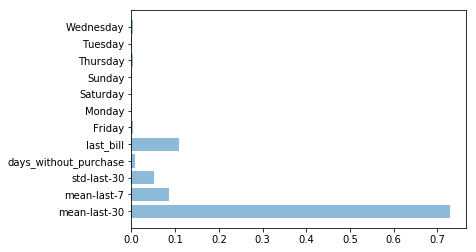

In [38]:
objects = X_train.columns
y_pos = np.arange(len(objects))
performance = model.feature_importances_

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects);